# PART-2 : Hyperparameter Optimization For The Human Freedom Index Model

<div class="alert alert-success">

The <a href="https://www.cato.org/human-freedom-index/2021 ">Human Freedom Index</a> measures economic freedoms such as the freedom to trade or to use sound money, and it captures the degree to which people are free to enjoy the major freedoms often referred to as civil liberties—freedom of speech, religion, association, and assembly— in the countries in the survey. In addition, it includes indicators on rule of law, crime and violence, freedom of movement, and legal discrimination against same-sex relationships. We also include nine variables pertaining to women-specific freedoms that are found in various categories of the index.

<u>Citation</u>

Ian Vásquez, Fred McMahon, Ryan Murphy, and Guillermina Sutter Schneider, The Human Freedom Index 2021: A Global Measurement of Personal, Civil, and Economic Freedom (Washington: Cato Institute and the Fraser Institute, 2021).

In [1]:
import pandas as pd
import numpy as np

<div class="alert alert-info"></b>

Loading the Human Freedom Index data ```df```.

The data is laoded from the following URL https://raw.githubusercontent.com/kailaharsha/human-freedom-index/main/hfi.csv 



<div class='alert alert-warning'>
    
The following columns are redundant and should be dropped:
* ```year```
* ```ISO```
* ```countries```
* All columns containing the word ```rank``` 
* All columns containing the word ```score```
    
</div>


### Setting up feature matrix (X) and target array (y)
We follow the below mentioned steps in order to get X & y : 
* Loading the data into a dataframe ```df```
* Removed ```year```,```ISO``` & ```countries``` columns from ```df```
* Checked if the columns contained ```rank``` or ```score``` key word and removed all the features containing either of the key words
* Checked if the target feature had any **NA** values, and we observed that there were indeed **113** rows in ```df``` where ```hf_quartile``` was NA. Hence, we removed all the rows where ```hf_quartile``` was missing. 
* After checking & removing the missing values in target variable, we split ```df``` and stored the independent variables and target variable in ```X``` & ```y``` respectively.


In [2]:
#loading HFI data to a dataframe
df=pd.read_csv('https://raw.githubusercontent.com/kailaharsha/human-freedom-index/main/hfi.csv')

#Deleting redundant features 
df = df.drop(['year', 'ISO', 'countries'], axis=1)

cols = list(df.columns)

del_cols=[]
for col in cols : 
    if ("rank" in col) | ("score" in col) : 
        del_cols.append(col)

#Deleting redundant features        
df=df.drop(del_cols, axis=1)

#Checking for NA values in the target variable
print("Checking for NA values in hf_quartile")
print(df.isna().sum(), "\n\n")

#Dropping the rows where the target variable is NA
df=df[df['hf_quartile'].notna()]

print("Checking for NA values after addressing them in the target variable")
print(df.isna().sum())

#Storing the independent variables in X and target variable in y
X=df.drop('hf_quartile', axis=1)
y=df['hf_quartile']

#Storing the column names of numerical & categorical features in different lists 
numerical_features = list(X.select_dtypes(exclude='object').columns)
categorical_feature = ['region']

Checking for NA values in hf_quartile
region                                 0
hf_quartile                          113
pf_rol_procedural                    731
pf_rol_civil                         731
pf_rol_criminal                      731
                                    ... 
ef_regulation_business_bribes         69
ef_regulation_business_licensing     144
ef_regulation_business_compliance    127
ef_regulation_business               117
ef_regulation                        100
Length: 114, dtype: int64 


Checking for NA values after addressing them in the target variable
region                                 0
hf_quartile                            0
pf_rol_procedural                    636
pf_rol_civil                         636
pf_rol_criminal                      636
                                    ... 
ef_regulation_business_bribes         34
ef_regulation_business_licensing      31
ef_regulation_business_compliance     14
ef_regulation_business                 4
ef_r

### Importing the warnings library & all the necessary modules of scikit learn


In [3]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In this part, we aim to optimize the hyperparameters of **all** the steps of the Machine learning lifecycle's pipeline. We create two functions called ```custom_pipe``` & ```grid_search``` to automate the process of **Scaler selection** and **ML model selection**. 

#### Description of the Hyperparameters of the pipeline that will be optimized in the subsequent cells consisting of various scenariois

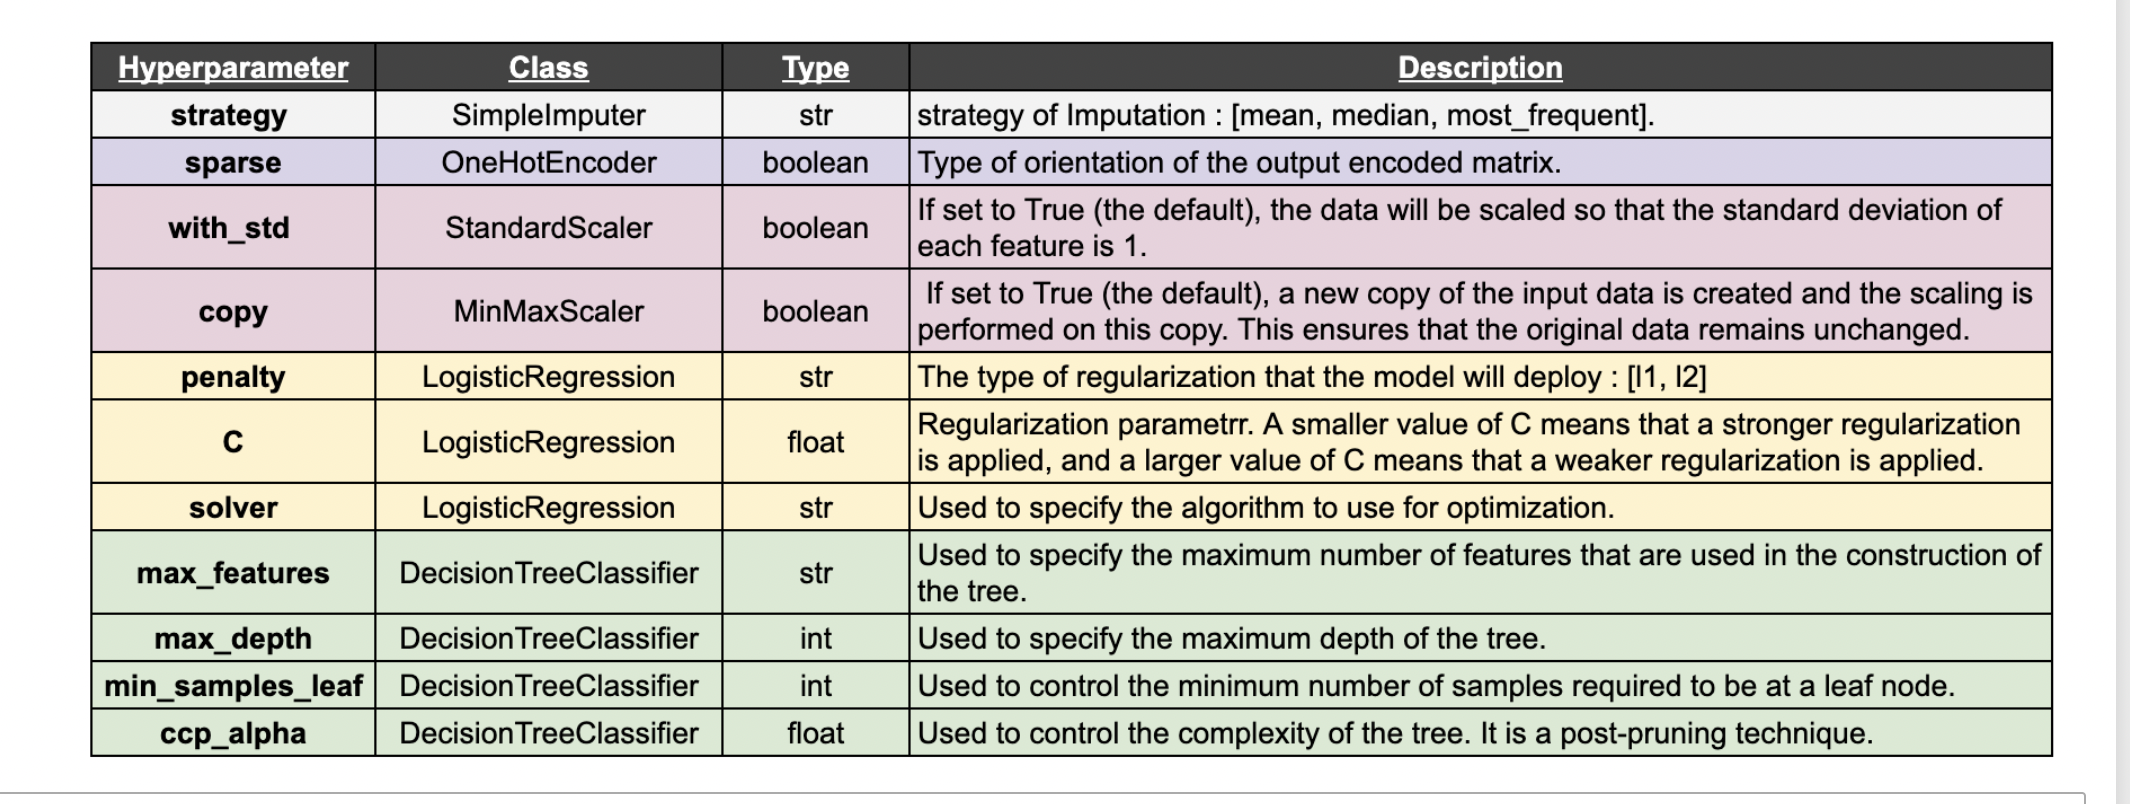

It might be a tricky task to find the prefix of a parameter that is embedded inside a pipeline. To get the right prefix, we used the **```pipe.get_params()```** method 

## The ```custom_pipe``` function

As mentioned above, we have created a function called **```custom_pipe()```** that takes the following necessary parameters :
* **```X```** - The feature matrix
* **```y```** - The target variable
* **```scaler```** - A sklearn object that depends on the choice of the scaler
* **```model```** - A sklearn object that depends on the choice of the ML model

The function returns an sklearn's **pipe** object. 

In [4]:
# YOUR CODE HERE
def custom_pipe(X, y, scaler, model):
    #Storing the column names of numerical & categorical features in different lists 
    numerical_features = list(X.select_dtypes(exclude='object').columns)
    categorical_feature = ['region']

    #Building the inner pipelines for numerical & categorical variables separately
    imp_num = SimpleImputer(strategy='most_frequent')

    steps_cat = [('imp_cat', SimpleImputer(strategy='most_frequent')),
                ('enc_cat', OneHotEncoder(sparse=False))]

    pipe_cat = Pipeline(steps_cat)

    #Building the column transformer
    transformer = ColumnTransformer([('num_features', imp_num, numerical_features),
                                     ('region', pipe_cat, categorical_feature)],
                                       remainder='passthrough')

    #Setting up the final pipeline
    steps = [('preprocessing', transformer),
            ('normalization', scaler),
            ('training', model)]

    pipe = Pipeline(steps)
    
    return pipe

## The ```grid_search``` function

We created a function called **```grid_search()```** that takes the following necessary parameters :
* **```X```** - The feature matrix
* **```y```** - The target variable
* **```pipe```** - A pipe object which is an output of the **```custom_pipe()```** function
* **```param_grid```** - A dictionary which takes parameter names as keys and list of iterables as values. 

The function takes the above parameters and fits the grid. 
It prints out the following :
* The **optimal parameters** of the pipeline 
* The **best score** obtained when trained with the validation set.

The function also returns the **grid** object.

**Additional considerations** : 
* We are using **```train_test_split()```** module to create a validation set with **10%** of the datapoints. This is being done to test the final optimized pipeline.
* To reduce the runtime, we are always considering only **three** folds for cross-validation.

In [5]:
def grid_search(X, y, pipe, param_grid):
    
    #Importing train_test_split module
    #Creating a validation set (10%) to later test the final optimized model
    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.90, test_size=0.10)
    
    #Importing the GridSearchCV module 
    #Setting up the grid and fitting it using 3 folds
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=3, verbose=1)
    grid.fit(X_train, y_train)
      
    class color:
       GREEN = '\033[92m'
       BOLD = '\033[1m'
       END = '\033[0m'
    
    print('\nThe best ' + color.BOLD + 'HYPERPARAMETERS' + color.END + ' of the pipeline for this scenario are : \n')
    for i in grid.best_params_.keys():
        print(str(i)+" : "+ color.BOLD + color.GREEN + str(grid.best_params_[i]) + color.END)

    score = grid.best_estimator_.score(X_test, y_test)

    print('\n\nThe '+ color.BOLD + 'ACCURACY ' + color.END + 'of the optimized pipeline when tested on validation set is ' + 
         color.BOLD + color.GREEN + str(round(score,3)) + color.END)
    
    print("\n")

    return grid

## The ```feat_imp``` function

We created a function called **```feat_imp()```** to visualize the feature importance of attributes in the feature matrix using a horizontal bar plot. The function takes the following necessary parameters : 
* **```grid```** - A GridSearchCV object that is the output of the **```grid_search()```** function

The function performs the following steps in the mentioned order : 
* It first stores the best pipeline using the **```.best_estimator```** method
* It stores absolute values of coefficients or the feature importances based on the choice of ML model being Logistic Regression or Decision Tree respectively. 
* By navigating through the optimal pipeline, it finds the new names of the features of the categorical features that were encoded using OneHotEncoder and concatenates these names with the feature names of the numerical features.
* Both the feature importance values and the names of the features are stored in a dataframe and sorted in a descneding order.
* Only the **top 15** features are plotted. 

In [6]:
def feat_imp(grid):
    
    #Storing the best estimator in a variable called est (which is a pipeline)
    est = grid.best_estimator_
    
    #Storing the coefficients of Logistic Regression model
    if hasattr(est[-1], 'coef_') :
        importance = np.abs(est[-1].coef_[0])
    
    #Storing the feature importance of a Decision Tree model
    if hasattr(est[-1], 'feature_importances_') :
        importance = est[-1].feature_importances_
    
    #Storing the new names of categorical features after one-hot encoding
    cat_features = list(est['preprocessing'].transformers_[1][1]['enc_cat'].get_feature_names(categorical_feature))
    
    #Concatenating names of numerical features with the categorical features
    feature_names = numerical_features + cat_features
    
    df_new = pd.DataFrame({'feature': feature_names, 'importance': importance})
    
    #Sort the features by importance
    df_new.sort_values(by='importance', ascending=False, inplace=True)

    #Only considering the top 15 features for plotting
    df_new = df_new.iloc[:15,:]
    
    #Plotting using the matplotlib library
    import matplotlib.pyplot as plt
    plt.barh(df_new['feature'], df_new['importance'])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance of top 15 features')
    plt.show()

#### The below cells contain 4 scenarios where each of the scenario contains a different combination of a Scaler, Model & Hyperparameters. We have obtained the best hyperparameters in each scenario and have also displayed the test score and the feature importance of the optimized model by calling the above custom functions 

## Scenario-1

* Choice of Scaler : **```StandardScaler()```** <br>
* Choice of Model :  **```LogisticRegression(max_iter=2000)```**

Fitting 3 folds for each of 288 candidates, totalling 864 fits

The best HYPERPARAMETERS of the pipeline for this scenario are : 

normalization__with_std : False
preprocessing__num_features__strategy : mean
preprocessing__region__enc_cat__sparse : True
preprocessing__region__imp_cat__strategy : most_frequent
training__C : 0.1
training__penalty : l2
training__solver : newton-cg


The ACCURACY of the optimized pipeline when tested on validation set is 0.963




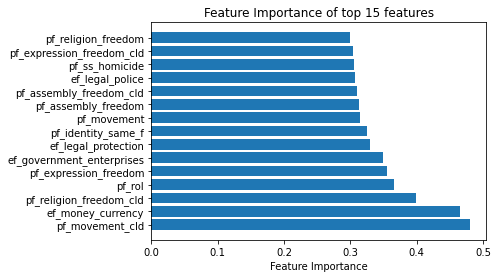

In [7]:
#Setting up the param_grid 
param_grid = {
'preprocessing__num_features__strategy' : ['most_frequent', 'mean', 'median'],
'preprocessing__region__imp_cat__strategy' :['most_frequent', 'mean', 'median'],
'preprocessing__region__enc_cat__sparse' : [True, False],
'normalization__with_std' : [True, False],
'training__penalty' : ['l1','l2'],
'training__C' : [0.1, 10],
'training__solver' : ['newton-cg', 'saga']
} 

#Building the pipeline by calling the custom_pipe() function
pipe = custom_pipe(X, y, StandardScaler(), LogisticRegression(max_iter=2000))

#Setting up the grid and fitting it by calling the grid_search() function
grid = grid_search(X, y, pipe, param_grid)

#Displaying the feature importance for top-15 features
feat_imp(grid)

## Scenario-2

* Choice of Scaler : **```MinMaxScaler()```** <br>
* Choice of Model :  **```LogisticRegression(max_iter=2000)```** 

Fitting 3 folds for each of 144 candidates, totalling 432 fits

The best HYPERPARAMETERS of the pipeline for this scenario are : 

normalization__copy : True
preprocessing__num_features__strategy : most_frequent
preprocessing__region__imp_cat__strategy : most_frequent
training__C : 10
training__penalty : l2
training__solver : newton-cg


The ACCURACY of the optimized pipeline when tested on validation set is 0.957




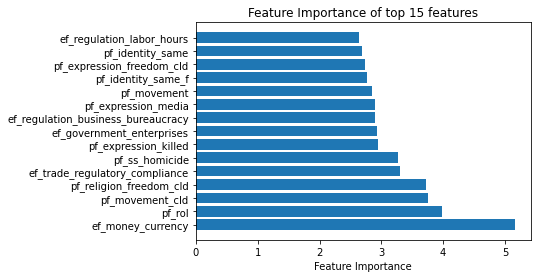

In [8]:
#Setting up the param_grid 
param_grid = {
'preprocessing__num_features__strategy' : ['most_frequent', 'mean', 'median'],
'preprocessing__region__imp_cat__strategy' :['most_frequent', 'mean', 'median'],
'normalization__copy' : [True, False],
'training__penalty' : ['l1','l2'],
'training__C' : [0.1, 10],
'training__solver' : ['newton-cg', 'saga']
}

#Building the pipeline by calling the custom_pipe() function
pipe = custom_pipe(X, y, MinMaxScaler(), LogisticRegression(max_iter=2000))

#Setting up the grid and fitting it by calling the grid_search() function
grid = grid_search(X, y, pipe, param_grid)

#Displaying the feature importance for top-15 features
feat_imp(grid)

## Scenario-3

* Choice of Scaler : **```StandardScaler()```** <br>
* Choice of Model :  **```DecisionTreeClassifier()```** 

Fitting 3 folds for each of 2916 candidates, totalling 8748 fits

The best HYPERPARAMETERS of the pipeline for this scenario are : 

normalization__with_std : False
preprocessing__num_features__strategy : mean
preprocessing__region__enc_cat__sparse : False
preprocessing__region__imp_cat__strategy : most_frequent
training__ccp_alpha : 0.001
training__max_depth : 7
training__max_features : None
training__min_samples_leaf : 2


The ACCURACY of the optimized pipeline when tested on validation set is 0.93




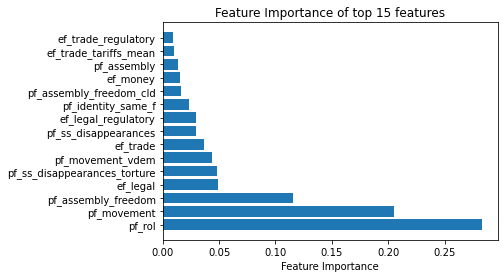

In [9]:
#Setting up the param_grid 
param_grid = {
'preprocessing__num_features__strategy' : ['most_frequent', 'mean', 'median'],
'preprocessing__region__imp_cat__strategy' :['most_frequent', 'mean', 'median'],
'preprocessing__region__enc_cat__sparse' : [True, False],
'normalization__with_std' : [True, False],
'training__max_features' : ['sqrt', 'log2', None],
'training__max_depth' : [5,6,7],
'training__min_samples_leaf' : [2,3,5],
'training__ccp_alpha' :  [0.0, 0.001, 0.01] 
} 

#Building the pipeline by calling the custom_pipe() function
pipe = custom_pipe(X, y, StandardScaler(), DecisionTreeClassifier())

#Setting up the grid and fitting it by calling the grid_search() function
grid = grid_search(X, y, pipe, param_grid)

#Displaying the feature importance for top-15 features
feat_imp(grid)

## Scenario-4

* Choice of Scaler : **```MinMaxScaler()```** <br>
* Choice of Model :  **```DecisionTreeClassifier()```** 

Fitting 3 folds for each of 2916 candidates, totalling 8748 fits

The best HYPERPARAMETERS of the pipeline for this scenario are : 

normalization__copy : False
preprocessing__num_features__strategy : most_frequent
preprocessing__region__enc_cat__sparse : False
preprocessing__region__imp_cat__strategy : most_frequent
training__ccp_alpha : 0.0
training__max_depth : 7
training__max_features : None
training__min_samples_leaf : 3


The ACCURACY of the optimized pipeline when tested on validation set is 0.888




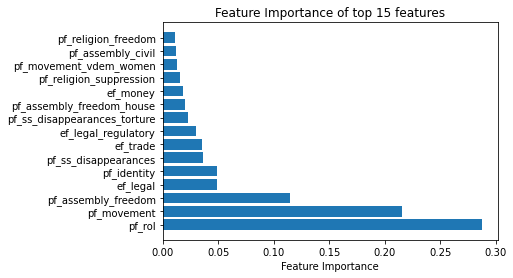

In [10]:
#Setting up the param_grid 
param_grid = {
'preprocessing__num_features__strategy' : ['most_frequent', 'mean', 'median'],
'preprocessing__region__imp_cat__strategy' :['most_frequent', 'mean', 'median'],
'preprocessing__region__enc_cat__sparse' : [True, False],
'normalization__copy' : [True, False],
'training__max_features' : ['sqrt', 'log2', None],
'training__max_depth' : [5,6,7],
'training__min_samples_leaf' : [2,3,5],
'training__ccp_alpha' :  [0.0, 0.001, 0.01] 
} 

#Building the pipeline by calling the custom_pipe() function
pipe = custom_pipe(X, y, MinMaxScaler(), DecisionTreeClassifier())

#Setting up the grid and fitting it by calling the grid_search() function
grid = grid_search(X, y, pipe, param_grid)

#Displaying the feature importance for top-15 features
feat_imp(grid)